In [296]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import math
import imutils

In [294]:
GAUSSIAN_BLUR_VALUE = 3
BINARY_THRESHOLD_VALUE = 120
BINARY_THRESHOLD_MAX =  255
DETECT_ELLIPSE_AREA_MIN_SIZE =  100
DETECT_ELLIPSE_AREA_MAX_SIZE =  2500
DETECT_GROUP_AREA_MIN_SIZE =  2500
DETECT_GROUP_AREA_MAX_SIZE =  12500
EXTRACT_MIN_SHARPNESS =  120

NN_MODEL_FOLDER =  'SavedModel'
CLASSIFICATION_THRESHOLDS =  {'pollen': 0.9999, 'varroa': 0.95, 'wasps': 0.8, 'cooling': 0.92}

EXTRACT_WIDTH = 75
EXTRACT_HEIGHT = 150


In [295]:
def detect_bees(frame, scale):

    # Helper method to calculate distance between to ellipses
    def near(p1,p2):
        return math.sqrt(math.pow(p1[0]-p2[0], 2) + math.pow(p1[1]-p2[1], 2))

    # Helper method to calculate the area of an ellipse
    def area(e1):
        return np.pi * e1[1][0] * e1[1][1]

    # Extract BGR and HSV channels
    b,g,r = cv2.split(frame)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)

    # Substract G and V
    o = 255 - (g - v)

    # Blur Image and perform a binary thresholding
    o = cv2.GaussianBlur(o, (9,9), GAUSSIAN_BLUR_VALUE)
    _, o = cv2.threshold(o, BINARY_THRESHOLD_VALUE, \
            BINARY_THRESHOLD_MAX, cv2.THRESH_BINARY)

    # Invert result
    o = 255 -o

    # Detect contours
    contours, hierarchy = cv2.findContours(o, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_KCOS)
    ellipses = []
    groups = []
    for i in range(len(contours)):

        # Only countours with more than five edges can fit an ellipse
        if(len(contours[i]) >= 5):

            # Fit ellipse
            e = cv2.fitEllipse(contours[i])

            # Skip too small detections
            if e[1][0] < 8 or e[1][1] < 8:
                continue

            # Only use ellipses with minium size
            ellipseArea = area(e)
            if ellipseArea > DETECT_ELLIPSE_AREA_MIN_SIZE \
                    and ellipseArea < DETECT_ELLIPSE_AREA_MAX_SIZE:

                # Scale ellipse to desired size
                e = ((e[0][0] * scale, e[0][1] * scale), (e[1][0] * scale, e[1][1] * scale), e[2])
                ellipses.append(e)
            elif ellipseArea > DETECT_GROUP_AREA_MIN_SIZE and \
                    ellipseArea < DETECT_GROUP_AREA_MAX_SIZE:

                # Scale ellipse to desired size
                e = ((e[0][0] * scale, e[0][1] * scale), (e[1][0] * scale, e[1][1] * scale), e[2])
                groups.append(e)

    # Merge nearby detection into one
    done = []
    skip = []
    solved = []
    for a in ellipses:

        # Find ellipses that are close to each other and store them as a group
        group = []
        for b in ellipses:

            # Skip self and already processed ellipes
            if (a,b) in done or (b,a) in done or a == b:
                continue
            done.append((a,b))

            # Calculate distance between both ellipses
            dist = near(a[0],b[0])
            if dist < 50:

                # Put them into the group
                if a not in group:
                    group.append(a)
                if b not in group:
                    group.append(b)

                # Remember which ellipses were processed
                if not a in skip:
                    skip.append(a)
                if not b in skip:
                    skip.append(b)

        # Isolate the ellipse with the biggest area
        if len(group):
            solved.append(max(group, key=area))

    # Merge isolated ellipses with remaining ones
    rest = list(filter(lambda x: x not in skip, ellipses))
    merged = rest + solved

    return merged, groups


In [297]:
def cutEllipseFromImage(el, img, w, h, scale=1):
    """! Cuts an ellipse from an given image and rotates it to 0 degree.
    The it calculates the sharpness of the resulting image and finaly
    it returns both, the image and the sharpness value
    @param  el      The cv2 ellipse to cut from the image
    @param  img     The image to cut the ellipse from
    @param  scale   The scale factor when interpreting the given ellipse
    @return  tuple  (image,sharpness)
    """

    # Scale the ellipse coordinates
    (x, y), _, angle = el
    x = int(x*scale)
    y = int(y*scale)

    # Calcuate the size of an image the covers the rotated ellipse
    ga = (math.pi) / 180 * angle
    xb = int(math.sqrt(
            math.pow(w,2)*math.pow(math.cos(ga),2)+
            math.pow(h,2)*math.pow(math.sin(ga),2)
            ))
    yb = int(math.sqrt(
            math.pow(w,2)*math.pow(math.sin(ga),2)+
            math.pow(h,2)*math.pow(math.cos(ga),2)
            ))

    # Calculate the resulting coordinates if the above
    # rectangle gets applied to the actual image
    tl_point = (int(x-xb), int(y-yb))
    br_point = (int(x+xb), int(y+yb))
    
    tl_mask = (max(0, tl_point[0]), max(0, tl_point[1]))
    br_mask = (min(img.shape[1], br_point[0]), min(img.shape[0], br_point[1]))
    
    tl_offset = (tl_mask[0]-tl_point[0], tl_mask[1]-tl_point[1])
    br_offset = (br_mask[0]-br_point[0], br_mask[1]-br_point[1])

    # Try to crop the original image to the calculated rectangle size
    # that covers the rotated ellipse and then rotate it back to 0 degrees
    crop_img1 = np.zeros((2 * yb, 2 * xb, img.shape[2]), np.uint8)
    crop_img1[tl_offset[1]:crop_img1.shape[0] + br_offset[1], tl_offset[0]:crop_img1.shape[1] + br_offset[0]] = img[
        tl_mask[1]:br_mask[1],
        tl_mask[0]:br_mask[0]
    ]

    crop_img2 = imutils.rotate_bound(crop_img1, -angle)

    # Crop the image to the desired size
    s0 = int((crop_img2.shape[0] -h)/2)
    s1 = int((crop_img2.shape[1] -w)/2)
    crop_img3 = crop_img2[s0:crop_img2.shape[0]-s0, s1:crop_img2.shape[1]-s1]
    crop_img3 = crop_img3[0:h, 0:w]

    return crop_img3


get image

In [312]:
# Open the video file
video = cv2.VideoCapture('/home/wn/Downloads/cooling_varroa_small.avi')

# Set the frame position to the desired frame number
frame_number = 40# Replace with the desired frame number
video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame from the video
success, frame = video.read()

# Check if the frame was successfully read
if success:
    # Display the frame
    cv2.imshow('Frame', frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print('Failed to read frame from the video')

# Release the video file
video.release()


In [313]:
display_img = frame.copy()

detect bees

In [314]:
detect_img = cv2.resize(frame,(320,180))
bees, groups = detect_bees(detect_img, 3)

In [315]:
# draw ellipses
for item in bees:
    cv2.ellipse(display_img, item, (0, 0, 255), 2)
for item in groups:
    cv2.ellipse(display_img, item, (255, 0, 0), 2)

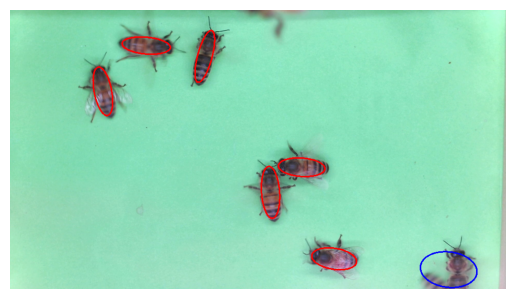

In [316]:
plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

extract image

In [317]:
images = []
for bee_pos in bees:
    img = cutEllipseFromImage(bee_pos, frame, EXTRACT_WIDTH, EXTRACT_HEIGHT, 1)
    images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

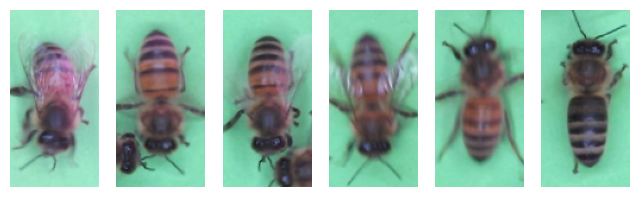

In [318]:
# Display each image in a separate subplot
fig, axs = plt.subplots(1, len(images), figsize=(8, 8))
for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()


classification

In [79]:
model = tf.keras.models.load_model(NN_MODEL_FOLDER)

In [80]:
model.summary()

Model: "beenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 75, 3)]         0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 75, 3)           0         ['input_1[0][0]']             
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 75, 3)           0         ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 147, 72, 64)          3136      ['rescaling_1[0][0]']         
                                                                                             

In [110]:
results = model.predict_on_batch(tf.convert_to_tensor(images))

In [111]:
result_entries = []
for num in range(len(images)):
    entry = []
    for lbl_id, lbl in enumerate(["varroa", "pollen", "wasps", "cooling"]):
        if results[lbl_id][num][0] > CLASSIFICATION_THRESHOLDS[lbl]:
            entry.append(lbl)
    result_entries.append(entry)
result_entries

[['cooling'],
 [],
 ['cooling'],
 ['cooling'],
 [],
 [],
 [],
 [],
 ['cooling'],
 [],
 [],
 [],
 []]

Full detection and classfication function

In [114]:
def detect_and_classify_bees(frame):
    # Resize the image
    img = cv2.resize(frame, (320, 180))

    # Detect bees
    bees, groups = detect_bees(img, 3)

    # Extract images
    images = []
    for bee_pos in bees:
        img = cutEllipseFromImage(bee_pos, frame, EXTRACT_WIDTH, EXTRACT_HEIGHT, 1)
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Classify images
    results = model.predict_on_batch(tf.convert_to_tensor(images))

    # Process classification results
    result_entries = []
    for num in range(len(images)):
        entry = []
        for lbl_id, lbl in enumerate(["varroa", "pollen", "wasps", "cooling"]):
            if results[lbl_id][num][0] > CLASSIFICATION_THRESHOLDS[lbl]:
                entry.append(lbl)
        result_entries.append(entry)

    return list(zip(bees, images, result_entries))


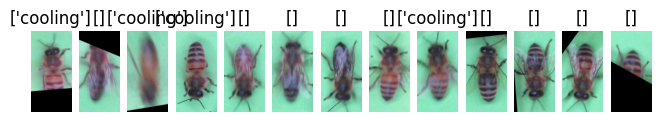

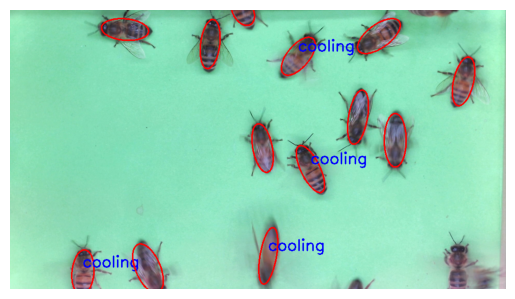

In [134]:
# Detect and classify bees
final_results = detect_and_classify_bees(frame)

# Display the results
fig, axs = plt.subplots(1, len(final_results), figsize=(8, 8))
for i, (pos, img, classifications) in enumerate(final_results):
    axs[i].imshow(img)
    axs[i].set_title(classifications)
    axs[i].axis('off')

plt.show()

# Create a copy of the frame
display_img = frame.copy()

# Draw ellipses on the copy of the frame
for pos, _, classifications in final_results:
    cv2.ellipse(display_img, pos, (0, 0, 255), 2)
    label = ', '.join(classifications)
    cv2.putText(display_img, label, (int(pos[0][0]), int(pos[0][1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

# Display the image
plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
